In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
BSIZE_SP = 512
MDATA_LIST = [b'title', b'date', b'plotname', b'flags',
              b'no. variables', b'no. points', b'dimensions',
              b'command', b'option']

class NGSpiceRaw:
    def __init__(self, fname: str, live: bool = True):
        self.fname = fname
        self.live = live

        self._reload()

    def _reload(self):
        self.arrs, self.plots = self._read_raw(self.fname)
        self.plot, self.arr = self.plots[-1], self.arrs[-1]
        print(f"Loaded {len(self.plots)} plots from {self.fname}")

    def _read_raw(self, fname: str):
        """
        Read a binary ngspice .raw file.

        Returns:
          arrs  : list of numpy structured arrays, one per plot
          plots : list of metadata dicts, parallel to arrs
        """
        with open(fname, 'rb') as fp:
            arrs = []
            plots = []
            plot = {}
            while True:
                line = fp.readline(BSIZE_SP)
                if not line:
                    break
                parts = line.split(b':', 1)
                if len(parts) != 2:
                    continue
                key, val = parts[0].lower(), parts[1].strip()
                if key in MDATA_LIST:
                    plot[key] = val
                if key == b'variables':
                    nvars   = int(plot[b'no. variables'])
                    npoints = int(plot[b'no. points'])
                    plot['varnames'] = []
                    plot['varunits'] = []
                    for _ in range(nvars):
                        ascii_line = fp.readline(BSIZE_SP).decode('ascii')
                        idx, name, *unit = ascii_line.split()
                        plot['varnames'].append(name)
                        plot['varunits'].append(unit[0])
                if key == b'binary':
                    # build dtype (complex if flagged, else float)
                    fmt = np.complex_ if b'complex' in plot[b'flags'] else float
                    row_dtype = np.dtype({
                        'names':   plot['varnames'],
                        'formats': [fmt]*len(plot['varnames'])
                    })
                    # read data block
                    data = np.fromfile(fp, dtype=row_dtype, count=npoints)
                    arrs.append(data)
                    plots.append(plot.copy())
                    plot.clear()
                    fp.readline()

        return arrs, plots
    
    def select(self, idx: int):
        """
        Select a plot by index.
        """
        if idx < -len(self.plots) or idx >= len(self.plots):
            raise IndexError("Index out of range")
        
        self.plot = self.plots[idx]
        self.arr = self.arrs[idx]

        return self.plot, self.arr
    
    @property
    def names(self):
        return self.arr.dtype.names
    
    def __getitem__(self, key):
        """
        Get a variable by name or index.
        """
        if self.live:
            self._reload()

        if key in self.names:
            return self.arr[key]
        else:
            raise KeyError(f"Variable '{key}' not found")
        
    def __setitem__(self, key, value):
        """
        Set a variable by name or index.
        """
        if self.live:
            self._reload()

        if key in self.names:
            raise KeyError(f"Variable '{key}' already exists")
        else:
            # Add new variable to the array
            new_dtype = np.dtype(self.arr.dtype.descr + [(key, value.dtype)])
            new_arr = np.zeros(self.arr.shape, dtype=new_dtype)
            for name in self.names:
                new_arr[name] = self.arr[name]
            new_arr[key] = value
            self.arr = new_arr
            self.arrs[-1] = new_arr
            self.plot['varnames'].append(key)
            self.plot['varunits'].append('')
            self.plot[b'no. variables'] = str(len(self.plot['varnames']))
            self.plot[b'no. points'] = str(len(self.arr))
            

In [3]:
raw = NGSpiceRaw('../designs/comparator/simulation/comparator_tb.raw', live=False)

Loaded 1 plots from ../designs/comparator/simulation/comparator_tb.raw


In [4]:
print("Fields:", raw.names)

Fields: ('time', 'v(x1.net3)', 'v(clk)', 'v(vdd)', 'v(out1)', 'v(out2)', 'v(x1.net2)', 'v(vss)', 'v(in_p)', 'v(x1.net1)', 'v(in_n)', 'v(net2)', 'v(net1)', 'v(x4.net4)', 'v(x4.net2)', 'v(out)', 'i(vnoise)', 'i(vin)', 'i(vclk)', 'i(vss)', 'i(vdd)', 'v(n.x4.xx5.nsg13_lv_pmos#NOI)', 'v(n.x4.xx5.nsg13_lv_pmos#GP)', 'v(n.x4.xx5.nsg13_lv_pmos#SI)', 'v(n.x4.xx5.nsg13_lv_pmos#DI)', 'v(n.x4.xx5.nsg13_lv_pmos#BP)', 'v(n.x4.xx5.nsg13_lv_pmos#BI)', 'v(n.x4.xx5.nsg13_lv_pmos#BS)', 'v(n.x4.xx5.nsg13_lv_pmos#BD)', 'v(n.x4.xx5.nsg13_lv_pmos#INT1)', 'v(n.x4.xx5.nsg13_lv_pmos#INT2)', 'v(n.x4.xx5.nsg13_lv_pmos#INT3)', 'v(n.x4.xx5.nsg13_lv_pmos#INT4)', 'v(n.x4.xx5.nsg13_lv_pmos#INT5)', 'v(n.x4.xx5.nsg13_lv_pmos#INT6)', 'v(n.x4.xx5.nsg13_lv_pmos#INT7)', 'v(n.x4.xx5.nsg13_lv_pmos#INT8)', 'v(n.x4.xx5.nsg13_lv_pmos#INT9)', 'v(n.x4.xx5.nsg13_lv_pmos#flow(RES1))', 'v(n.x4.xx5.nsg13_lv_pmos#flow(SPLINE1))', 'v(n.x4.xx5.nsg13_lv_pmos#flow(RES2))', 'v(n.x4.xx5.nsg13_lv_pmos#flow(SPLINE2))', 'v(n.x4.xx5.nsg13_lv_pmo

In [5]:
from typing import Optional

def plot_digital_signals(raw: NGSpiceRaw, signals: list[str], time_range: Optional[tuple[float, float]] = None, spacing: float = 1.25):

    time = raw['time']

    plt.figure(figsize=(16, 2 + len(signals)))
    plt.title(raw.plot[b'title'].decode('ascii'))

    added_signals = []
    for i, signal in enumerate(signals):
        if isinstance(signal, str):
            signal_name = f"v({signal.lower()})" if '(' not in signal else signal.lower()
            if signal_name not in raw.names:
                print(f"Signal '{signal_name}' not found in raw data")
                continue

            signal = raw[signal_name]
            
        elif isinstance(signal, tuple):
            signal_name = signal[0]
            signal = signal[1]

            if signal.ndim != 1:
                print(f"Signal '{signal[1]}' is not a 1D array")
                continue

        else:
            print(f"Unsupported signal type: {type(signal)}")
            continue

        plt.axhline(-i * spacing, color='black', lw=1.0, ls='--')
        plt.axhline(-i * spacing + 0.5, color='black', lw=0.75, ls='--')
        plt.axhline(-i * spacing + 1.0, color='black', lw=1.0, ls='--')
        # Gray background for each signal
        plt.fill_between(time, -i * spacing, -i * spacing + 1.0, color='lightgray', alpha=0.5)

        if signal.max() != signal.min():
            signal = (signal - signal.min()) / (signal.max() - signal.min())
        elif signal.max() == 0:
            signal = np.zeros_like(signal)
        else:
            signal = np.ones_like(signal)

        plt.plot(time, signal - i * spacing)
        added_signals.append(signal_name)

    # Replace y label ticks with signal names
    plt.xlabel('Time [s]')
    labels = plt.yticks([-i * spacing for i in range(len(added_signals))], added_signals)
    for i, label in enumerate(labels[1]):
        label.set_horizontalalignment('right')
        label.set_verticalalignment('bottom')
        label.set_color(f"C{i}")

    if time_range is not None:
        plt.xlim(time_range)
    else:
        plt.xlim(time[0], time[-1])

    plt.grid(axis='x', which='both', lw=0.75, ls='--', color='black')
    plt.show()

In [6]:
out_diff = raw['v(out2)'] - raw['v(out1)']

out_cleaned = np.where(raw['v(out2)'] > 0.9, np.where(raw['v(out1)'] < 0.9, 1.0, 0.0), 0.0)

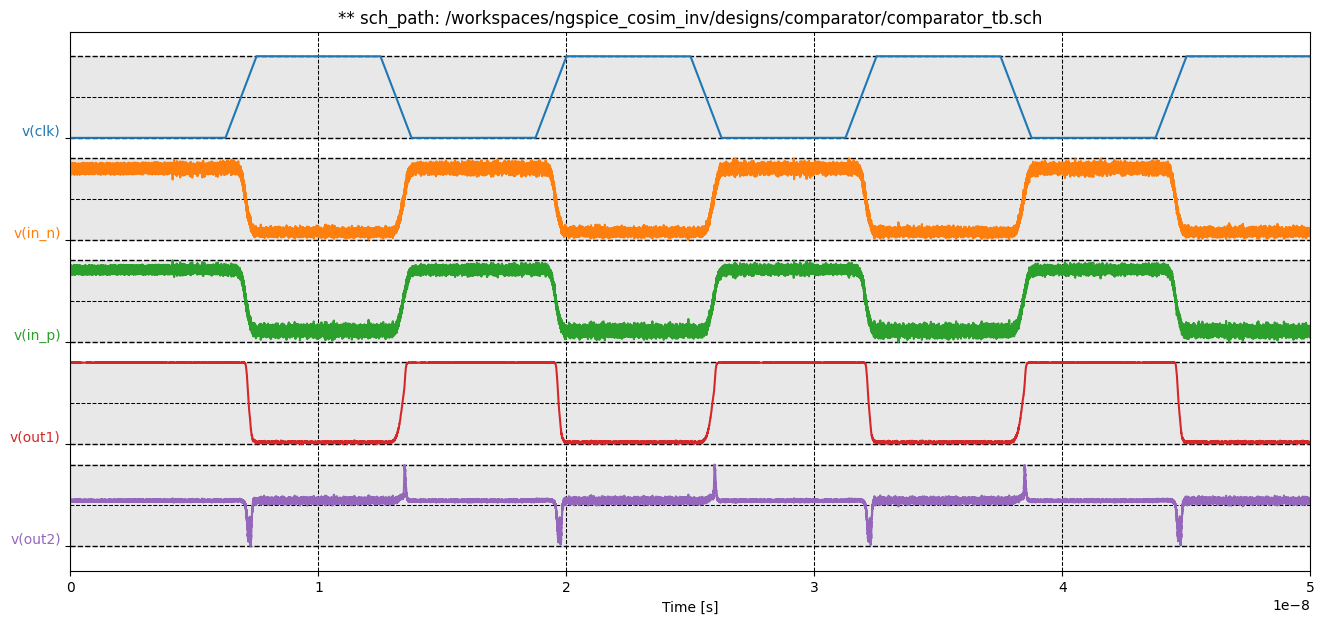

In [7]:
plot_digital_signals(
    raw,
    ['clk', 'in_n', 'in_p', 'v(out1)', 'v(out2)'],
    # time_range=(2.45e-5, 2.65e-5)
)

In [8]:
t = raw['time']
vout = raw['v(out1)']

In [9]:
Vdd = 1.5
Vth = Vdd / 2
crossings = []
for i in range(len(t)-1):
    if vout[i] >= Vth > vout[i+1]:
        # linear interpolation between points
        t0, v0 = t[i], vout[i]
        t1, v1 = t[i+1], vout[i+1]
        tc = t0 + (Vth - v0) / (v1 - v0) * (t1 - t0)
        crossings.append(tc)
crossings = np.array(crossings)

crossings

array([7.18180019e-09, 1.96821693e-08, 3.21816046e-08, 4.46808004e-08])

In [10]:
f = 80e6                 # your clock frequency
ideal = np.arange(len(crossings)) / f + 0.5745/f
print(f"Expected crossings at: {ideal}")
errors = crossings - ideal
jitter_rms = np.std(errors)

print(f"Decision jitter (1 rho) = {jitter_rms*1e15:.2f} fs")

Expected crossings at: [7.181250e-09 1.968125e-08 3.218125e-08 4.468125e-08]
Decision jitter (1 rho) = 500.83 fs


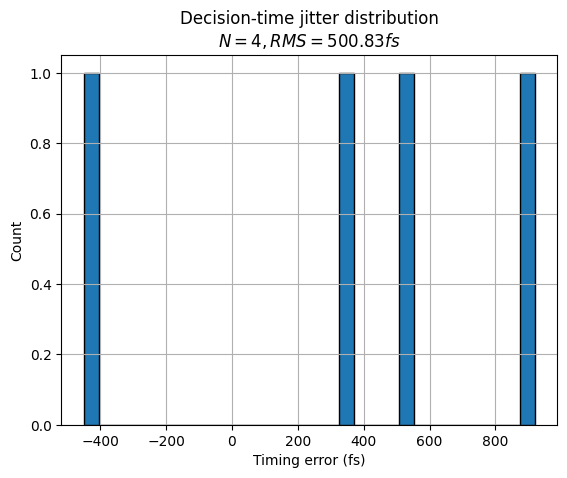

In [11]:
plt.hist(errors*1e15, bins=30, edgecolor='k')
plt.xlabel('Timing error (fs)')
plt.ylabel('Count')
plt.title(f'Decision-time jitter distribution\n$N = {len(errors)}, RMS = {jitter_rms*1e15:.2f} fs$')
plt.grid(True)
plt.show()